<a href="https://colab.research.google.com/github/costpetrides/Fluid-Dynamics/blob/main/2D-Cavity-Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cavity Flow in 2D using Finite Difference Method

Unsteady Term  : Forward Euler Scheme
Convection Term: Backward Difference Scheme
Diffusion Term : Central Difference Scheme

Velocity of Cavity Lid: 1 m/s
Enter the number of Iterations to Solve: 1000
------------------------------------------------
Calculating Numerical Solution......
------------------------------------------------
------------------------------------------------
Iteration Completed!
------------------------------------------------
------------------------------------------------
Plotting Pressure Field
------------------------------------------------


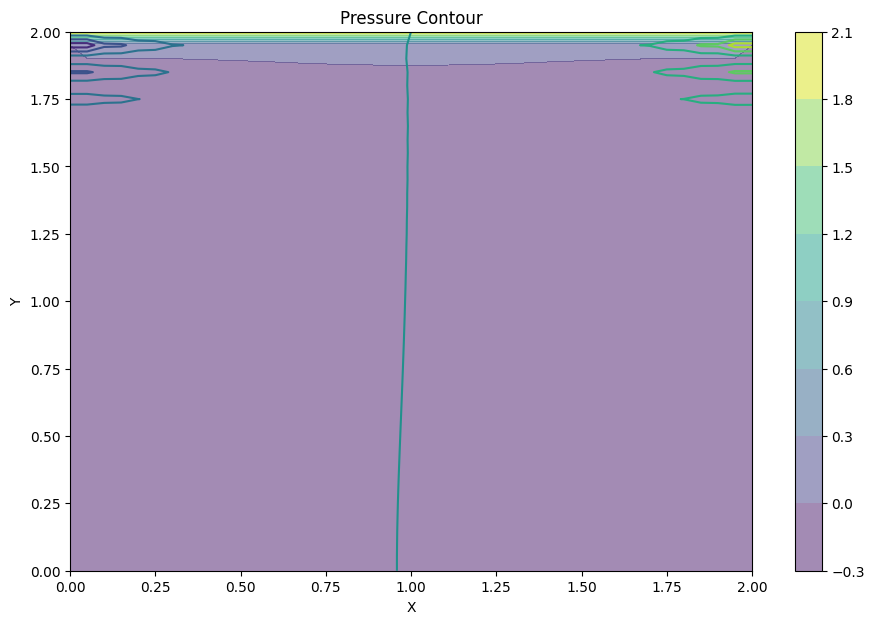

------------------------------------------------
Plotting Velocity Vectors
------------------------------------------------


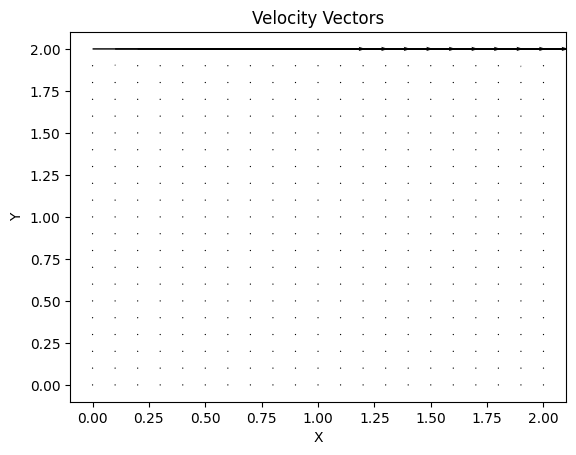

------------------------------------------------
Plotting Velocity Field
------------------------------------------------


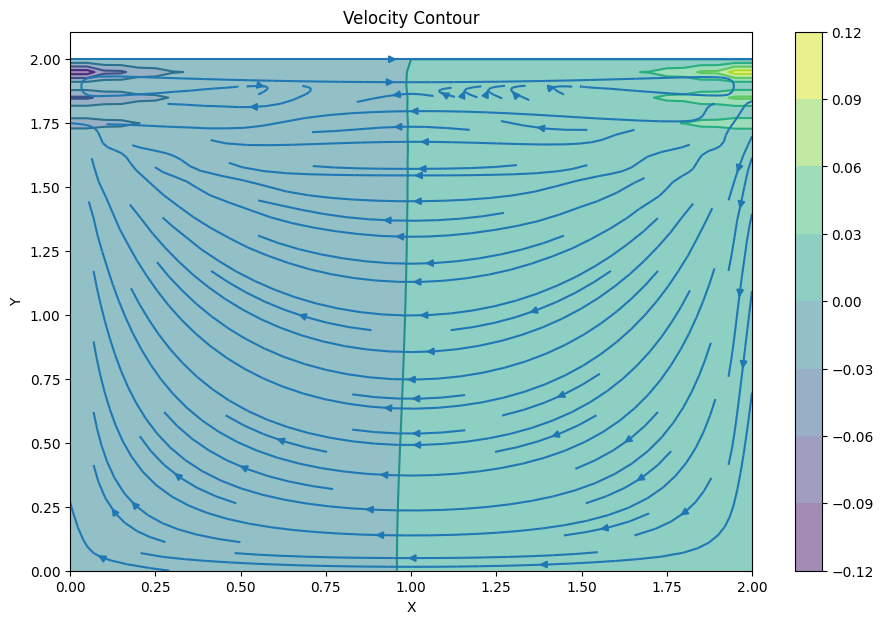

In [8]:
import numpy
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D

lineSingle = '------------------------------------------------'

print("Cavity Flow in 2D using Finite Difference Method\n")

print("Unsteady Term  : Forward Euler Scheme")
print("Convection Term: Backward Difference Scheme")
print("Diffusion Term : Central Difference Scheme\n")

print("Velocity of Cavity Lid: 1 m/s")

nx = 41            #Grid Points along X direction
ny = 41            #Grid Points along Y direction

iteration = input('Enter the number of Iterations to Solve: ')

if iteration.isdigit() == False:
    print("Please provide an integer\n")
else:
    iteration = int(iteration)


nt = 100     #Number of Time Step

#Grid Spacing

dx = 2 / (nx - 1)
dy = 2 / (ny - 1)

x  = numpy.linspace(0, 2, nx)
y  = numpy.linspace(0, 2, ny)
X,Y = numpy.meshgrid(x, y)           #Generating a 2D Mesh

#fluid property

rho = 1                            #Density
nu  = 0.001                          #Viscosity

dt  = 0.001                        #time step size

#initilization

u = numpy.zeros((ny,nx))
v = numpy.zeros((ny,nx))
p = numpy.zeros((ny,nx))
b = numpy.zeros((ny,nx))

#Solving RHS of poisson eqution in a separate function

def build_up_p(b, rho, dt, u, v, dx, dy):

    b[1:-1,1:-1] = (rho *(1 / dt * ((u[1:-1,2:] - u[1:-1,0:-2]) / (2*dx) + (v[2:,1:-1] - v[:-2,1:-1]) / (2 * dy))
                          - ((u[1:-1,2:] - u[1:-1,0:-2]) / (2 * dx))**2 -
                             2 * ((u[2:,1:-1] - u[:-2,1:-1]) / (2 * dy) * (v[1:-1,2:] - v[1:-1,:-2]) / (2 * dx))
                          - ((v[2:,1:-1] - v[:-2,1:-1]) / (2 * dy))**2))

    return b

#Solving Poisson Equation for Pressure

def pressure_poisson(p, dx, dy, b):
    pn = numpy.empty_like(p)
    pn = p.copy()

    for q in range(iteration):
        pn = p.copy()
        p[1:-1,1:-1] = (((pn[1:-1,2:]+pn[1:-1,:-2])*dy**2 + (pn[2:,1:-1]+pn[:-2,1:-1])*dx**2) /
                        (2*(dx**2 + dy**2)) - dx**2 * dy**2 /(2*(dx**2 + dy**2)) * b[1:-1,1:-1])

        #Boundary Condition

        p[:,-1] = p[:,-2]   #dp/dx = 2 at x = 2
        p[0,:]  = p[1,:]    #dp/dy = 0 at y = 0
        p[:,0]  = p[:,1]    #dp/dx = 0 at x = 0
        p[-1,:] = 0         #p = 0 at y = 0  pressure outlet, atmospheric presure

    return p


def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    un = numpy.empty_like(u)
    vn = numpy.empty_like(v)
    b  = numpy.zeros((ny,nx))

    for n in range(nt):
        un = u.copy()
        vn = v.copy()

        b = build_up_p(b, rho, dt, u, v, dx, dy)

        #Calling the Pressure Field

        p = pressure_poisson(p, dx, dy, b)

        #Solving X Momentum

        u[1:-1,1:-1] = (un[1:-1,1:-1]-
                        un[1:-1,1:-1] * dt / dx *
                        (un[1:-1,1:-1] - un[1:-1,:-2])-
                        vn[1:-1,1:-1] * dt / dy *
                        (un[1:-1,1:-1] - un[:-2,1:-1]) -
                        dt / (2 * rho * dx) * (p[1:-1,2:] - p[1:-1,:-2]) +
                        nu * (dt / dx**2 *
                        (un[1:-1,2:] - 2 * un[1:-1,1:-1] + un[1:-1,:-2]) +
                            dt / dy**2 *
                            (un[2:,1:-1] - 2 * un[1:-1,1:-1] + un[:-2,1:-1])))

        #Solving Y Momentum

        v[1:-1,1:-1] = (vn[1:-1,1:-1]-
                        un[1:-1,1:-1] * dt / dx *
                        (vn[1:-1,1:-1] - vn[1:-1,:-2]) -
                        vn[1:-1,1:-1] * dt / dy *
                        (vn[1:-1,1:-1] - vn[:-2,1:-1]) -
                        dt / (2 * rho * dy) * (p[2:,1:-1] - p[:-2,1:-1]) +
                        nu * (dt / dx**2 *
                        (vn[1:-1,2:] - 2 * vn[1:-1,1:-1] + vn[1:-1,:-2]) +
                        dt / dy**2 *
                        (vn[2:,1:-1] - 2 * vn[1:-1,1:-1] + vn[:-2,1:-1])))

        #Boundary Condition

        u[0,:]  = 0
        u[:,0]  = 0
        u[:,-1] = 0
        u[-1,:] = 2       #at cavity lid velocity is 1
        v[0,:]  = 0
        v[-1,:] = 0
        v[:,0]  = 0
        v[:,-1] = 0

    return u, v, p

print(lineSingle)
print("Calculating Numerical Solution......")
print(lineSingle)

u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

print(lineSingle)
print("Iteration Completed!")
print(lineSingle)


fig = pyplot.figure(figsize=(11,7),dpi=100)

#plotting pressure contour

print(lineSingle)
print("Plotting Pressure Field")
print(lineSingle)

pyplot.contourf(X,Y,u, alpha=0.5,cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p)
pyplot.xlabel('X')
pyplot.ylabel('Y')
pyplot.title('Pressure Contour')
pyplot.show()

#plotting vector field

print(lineSingle)
print("Plotting Velocity Vectors")
print(lineSingle)

pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
pyplot.xlabel('X')
pyplot.ylabel('Y')
pyplot.title('Velocity Vectors')
pyplot.show()

#plotting velocity contour

print(lineSingle)
print("Plotting Velocity Field")
print(lineSingle)

fig = pyplot.figure(figsize=(11, 7), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.streamplot(X, Y, u, v)
pyplot.xlabel('X')
pyplot.ylabel('Y')
pyplot.title('Velocity Contour')
pyplot.show()